<a href="https://colab.research.google.com/github/jyotikashyap85399-tech/Image-classification/blob/main/NLP_assignment_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Cell 0: Setup
!pip install -q gdown
!pip install -q torchtext sklearn

import os
import random
import math
import gdown
import pandas as pd
import numpy as np
from tqdm.auto import tqdm

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, random_split
import torch.nn.functional as F
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence

from sklearn.metrics import accuracy_score, precision_recall_fscore_support, confusion_matrix
import matplotlib.pyplot as plt
%matplotlib inline

# Reproducibility
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(SEED)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)

# Download dataset from Google Drive using file id from your link
file_id = "1A8mqzrqeTUj8Rbh52w0mru_GxONjHVJv"
output = "reviews.csv"
gdown.download(f"https://drive.google.com/uc?id={file_id}", output, quiet=False)
df = pd.read_csv(output)
print("Loaded:", df.shape)
df.head()


  error: subprocess-exited-with-error
  
  × python setup.py egg_info did not run successfully.
  │ exit code: 1
  ╰─> See above for output.
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
  Preparing metadata (setup.py) ... error
error: metadata-generation-failed

× Encountered error while generating package metadata.
╰─> See above for output.

note: This is an issue with the package mentioned above, not pip.
hint: See above for details.
Device: cuda


Downloading...
From: https://drive.google.com/uc?id=1A8mqzrqeTUj8Rbh52w0mru_GxONjHVJv
To: /content/reviews.csv
100%|██████████| 66.2M/66.2M [00:00<00:00, 72.2MB/s]


Loaded: (50000, 2)


,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


In [2]:
# Cell 1: Preprocessing helpers
import re
from collections import Counter

# change these if your CSV columns are differently named
text_col = 'review'
label_col = 'label'

def clean_text(text):
    # basic cleaning: lowercase, remove non-alphanumeric (keep basic punctuation optionally)
    text = str(text).lower()
    # remove urls
    text = re.sub(r'http\S+|www\S+|https\S+', '', text)
    # remove HTML tags
    text = re.sub(r'<.*?>', '', text)
    # keep letters and basic punctuation (space, .,!?), replace others with space
    text = re.sub(r"[^a-z0-9\s\.\,\!\?']", " ", text)
    # collapse multiple spaces
    text = re.sub(r'\s+', ' ', text).strip()
    return text

def tokenize(text):
    # simple whitespace + punctuation-aware tokenization
    # split on spaces; keep punctuation as part of token where attached to word
    return text.split()

# build vocabulary (start index at 1; 0 reserved for padding)
def build_vocab(texts, min_freq=1, max_size=None, reserved_tokens=None):
    if reserved_tokens is None:
        reserved_tokens = []
    counter = Counter()
    for t in texts:
        counter.update(tokenize(clean_text(t)))
    # filter by min_freq
    words_and_freq = [(w,c) for w,c in counter.items() if c>=min_freq]
    words_and_freq.sort(key=lambda x: (-x[1], x[0]))
    if max_size:
        words_and_freq = words_and_freq[:max_size]
    idx = 1  # reserve 0 for padding
    stoi = {}
    for w,_ in words_and_freq:
        stoi[w] = idx
        idx += 1
    # add reserved tokens (e.g. <unk>)
    for tk in reserved_tokens:
        if tk not in stoi:
            stoi[tk] = idx
            idx += 1
    itos = {i:w for w,i in stoi.items()}
    itos[0] = "<pad>"
    return stoi, itos

def text_to_sequence(text, stoi, unk_idx=None):
    tokens = tokenize(clean_text(text))
    seq = [stoi[t] if t in stoi else (unk_idx if unk_idx is not None else 0) for t in tokens]
    return seq

def pad_truncate(seq, max_len, pad_value=0):
    if len(seq) >= max_len:
        return seq[:max_len]
    else:
        return seq + [pad_value] * (max_len - len(seq))


In [3]:
# Set correct column names
text_col = "review"
label_col = "sentiment"

# If sentiment is text, convert to 0/1
df['sentiment'] = df['sentiment'].replace({'negative': 0, 'positive': 1})

# Cell 2: Build vocab, sequences, splits
texts = df[text_col].astype(str).tolist()
labels = df[label_col].astype(int).tolist()

# Preprocessing hyperparams
min_freq = 1
max_vocab = 30000
reserved = ["<unk>"]
stoi, itos = build_vocab(texts, min_freq=min_freq, max_size=max_vocab, reserved_tokens=reserved)
unk_idx = stoi.get("<unk>", max(stoi.values())+1 if len(stoi)>0 else 1)
vocab_size = max(stoi.values()) + 1
print("Vocab size (including pad & unk):", vocab_size)

# Sequence hyperparams
MAX_LEN = 100
sequences = [pad_truncate(text_to_sequence(t, stoi, unk_idx=unk_idx), MAX_LEN) for t in texts]

data = list(zip(sequences, labels))

# Train/Val/Test split
total = len(data)
train_frac, val_frac = 0.8, 0.1
train_size = int(total * train_frac)
val_size = int(total * val_frac)
test_size = total - train_size - val_size

random.shuffle(data)
train_data = data[:train_size]
val_data = data[train_size:train_size+val_size]
test_data = data[train_size+val_size:]

print("Sizes -> total:", total, "train:", len(train_data), "val:", len(val_data), "test:", len(test_data))


/tmp/ipython-input-444543915.py:6: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df['sentiment'] = df['sentiment'].replace({'negative': 0, 'positive': 1})


Vocab size (including pad & unk): 30002
Sizes -> total: 50000 train: 40000 val: 5000 test: 5000


In [4]:
df.head()
df.columns


Index(['review', 'sentiment'], dtype='object')

In [5]:
# Cell 3: Dataset and DataLoader
class ReviewDataset(Dataset):
    def __init__(self, seq_label_pairs):
        self.data = seq_label_pairs
    def __len__(self):
        return len(self.data)
    def __getitem__(self, idx):
        seq, label = self.data[idx]
        return torch.tensor(seq, dtype=torch.long), torch.tensor(label, dtype=torch.float)

batch_size = 64

train_ds = ReviewDataset(train_data)
val_ds = ReviewDataset(val_data)
test_ds = ReviewDataset(test_data)

train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_ds, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_ds, batch_size=batch_size, shuffle=False)

print("DataLoaders ready. Example batch shapes:")
for x,y in train_loader:
    print(x.shape, y.shape)
    break


DataLoaders ready. Example batch shapes:
torch.Size([64, 100]) torch.Size([64])


In [6]:
# Cell 4: Models
class SimpleRNNClassifier(nn.Module):
    def __init__(self, vocab_size, emb_dim=100, hidden_dim=128, num_layers=1, dropout=0.3):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, emb_dim, padding_idx=0)
        self.rnn = nn.RNN(input_size=emb_dim, hidden_size=hidden_dim,
                          num_layers=num_layers, batch_first=True, nonlinearity='tanh', dropout=dropout if num_layers>1 else 0)
        self.dropout = nn.Dropout(dropout)
        self.fc = nn.Linear(hidden_dim, 1)  # binary
    def forward(self, x):
        # x: batch x seq_len
        emb = self.embedding(x)  # b x s x e
        out, h_n = self.rnn(emb)  # out: b x s x hidden ; h_n: num_layers x b x hidden
        last_hidden = h_n[-1]  # b x hidden
        out = self.dropout(last_hidden)
        logits = self.fc(out).squeeze(1)
        return logits

class LSTMClassifier(nn.Module):
    def __init__(self, vocab_size, emb_dim=100, hidden_dim=128, num_layers=1, bidirectional=False, dropout=0.3):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, emb_dim, padding_idx=0)
        self.lstm = nn.LSTM(emb_dim, hidden_dim, num_layers=num_layers, batch_first=True,
                            bidirectional=bidirectional, dropout=dropout if num_layers>1 else 0)
        self.dropout = nn.Dropout(dropout)
        self.bidirectional = bidirectional
        self.hidden_dim = hidden_dim
        fc_in = hidden_dim * (2 if bidirectional else 1)
        self.fc = nn.Linear(fc_in, 1)
    def forward(self, x):
        emb = self.embedding(x)
        out, (h_n, c_n) = self.lstm(emb)
        # For LSTM: use last layer's hidden; if bidirectional concat both directions
        if self.bidirectional:
            last_hidden = torch.cat((h_n[-2], h_n[-1]), dim=1)
        else:
            last_hidden = h_n[-1]
        out = self.dropout(last_hidden)
        logits = self.fc(out).squeeze(1)
        return logits


In [7]:
# Cell 5: Training and eval helpers
def train_epoch(model, loader, optimizer, criterion):
    model.train()
    losses = []
    preds_all = []
    labels_all = []
    for x_batch, y_batch in loader:
        x_batch = x_batch.to(device)
        y_batch = y_batch.to(device)
        optimizer.zero_grad()
        logits = model(x_batch)
        loss = criterion(logits, y_batch)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=5)
        optimizer.step()
        losses.append(loss.item())
    return np.mean(losses)

def eval_model(model, loader, criterion):
    model.eval()
    losses = []
    preds = []
    labels = []
    with torch.no_grad():
        for x_batch, y_batch in loader:
            x_batch = x_batch.to(device)
            y_batch = y_batch.to(device)
            logits = model(x_batch)
            loss = criterion(logits, y_batch)
            losses.append(loss.item())
            probs = torch.sigmoid(logits).detach().cpu().numpy()
            preds.extend((probs >= 0.5).astype(int).tolist())
            labels.extend(y_batch.detach().cpu().numpy().astype(int).tolist())
    avg_loss = np.mean(losses)
    acc = accuracy_score(labels, preds)
    prec, rec, f1, _ = precision_recall_fscore_support(labels, preds, average='binary', zero_division=0)
    cm = confusion_matrix(labels, preds)
    return {
        'loss': avg_loss,
        'acc': acc,
        'prec': prec,
        'rec': rec,
        'f1': f1,
        'cm': cm,
        'preds': preds,
        'labels': labels
    }


In [8]:
# Cell 6: Hyperparams and training
vocab_size = vocab_size  # from earlier
embedding_dim = 150
hidden_dim = 128
num_layers = 1
dropout = 0.3
lr = 1e-3
num_epochs = 8

# Instantiate models
rnn_model = SimpleRNNClassifier(vocab_size=vocab_size, emb_dim=embedding_dim, hidden_dim=hidden_dim, num_layers=num_layers, dropout=dropout).to(device)
lstm_model = LSTMClassifier(vocab_size=vocab_size, emb_dim=embedding_dim, hidden_dim=hidden_dim, num_layers=num_layers, bidirectional=False, dropout=dropout).to(device)

rnn_opt = torch.optim.Adam(rnn_model.parameters(), lr=lr)
lstm_opt = torch.optim.Adam(lstm_model.parameters(), lr=lr)
criterion = nn.BCEWithLogitsLoss()

# training loops that store losses for plotting
rnn_hist = {'train_loss':[], 'val_loss':[], 'val_acc':[]}
lstm_hist = {'train_loss':[], 'val_loss':[], 'val_acc':[]}

for epoch in range(1, num_epochs+1):
    # RNN
    rnn_train_loss = train_epoch(rnn_model, train_loader, rnn_opt, criterion)
    rnn_eval = eval_model(rnn_model, val_loader, criterion)
    rnn_hist['train_loss'].append(rnn_train_loss)
    rnn_hist['val_loss'].append(rnn_eval['loss'])
    rnn_hist['val_acc'].append(rnn_eval['acc'])

    # LSTM
    lstm_train_loss = train_epoch(lstm_model, train_loader, lstm_opt, criterion)
    lstm_eval = eval_model(lstm_model, val_loader, criterion)
    lstm_hist['train_loss'].append(lstm_train_loss)
    lstm_hist['val_loss'].append(lstm_eval['loss'])
    lstm_hist['val_acc'].append(lstm_eval['acc'])

    print(f"Epoch {epoch}/{num_epochs} | RNN: train_loss={rnn_train_loss:.4f}, val_loss={rnn_eval['loss']:.4f}, val_acc={rnn_eval['acc']:.4f} | LSTM: train_loss={lstm_train_loss:.4f}, val_loss={lstm_eval['loss']:.4f}, val_acc={lstm_eval['acc']:.4f}")


Epoch 1/8 | RNN: train_loss=0.6960, val_loss=0.6900, val_acc=0.5348 | LSTM: train_loss=0.6837, val_loss=0.6787, val_acc=0.6076
Epoch 2/8 | RNN: train_loss=0.6861, val_loss=0.6917, val_acc=0.5652 | LSTM: train_loss=0.6105, val_loss=0.5599, val_acc=0.7242
Epoch 3/8 | RNN: train_loss=0.6656, val_loss=0.6828, val_acc=0.5836 | LSTM: train_loss=0.5109, val_loss=0.5321, val_acc=0.7352
Epoch 4/8 | RNN: train_loss=0.6528, val_loss=0.6947, val_acc=0.5348 | LSTM: train_loss=0.3939, val_loss=0.4222, val_acc=0.8062
Epoch 5/8 | RNN: train_loss=0.6611, val_loss=0.7023, val_acc=0.5418 | LSTM: train_loss=0.3143, val_loss=0.4134, val_acc=0.8140
Epoch 6/8 | RNN: train_loss=0.6286, val_loss=0.6810, val_acc=0.5926 | LSTM: train_loss=0.2491, val_loss=0.4293, val_acc=0.8280
Epoch 7/8 | RNN: train_loss=0.6049, val_loss=0.7001, val_acc=0.5654 | LSTM: train_loss=0.1940, val_loss=0.4391, val_acc=0.8226
Epoch 8/8 | RNN: train_loss=0.6030, val_loss=0.7030, val_acc=0.5736 | LSTM: train_loss=0.1471, val_loss=0.5077,

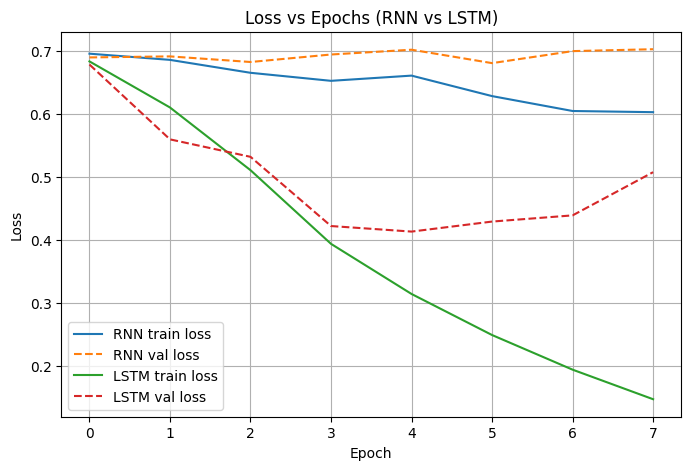

In [9]:
# Cell 7: Plot loss curves
plt.figure(figsize=(8,5))
plt.plot(rnn_hist['train_loss'], label='RNN train loss', linestyle='-')
plt.plot(rnn_hist['val_loss'], label='RNN val loss', linestyle='--')
plt.plot(lstm_hist['train_loss'], label='LSTM train loss', linestyle='-')
plt.plot(lstm_hist['val_loss'], label='LSTM val loss', linestyle='--')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss vs Epochs (RNN vs LSTM)')
plt.legend()
plt.grid(True)
plt.show()


In [10]:
# Cell 8: Evaluate on test
rnn_test = eval_model(rnn_model, test_loader, criterion)
lstm_test = eval_model(lstm_model, test_loader, criterion)

def print_metrics(name, res):
    print(f"--- {name} ---")
    print(f"Loss: {res['loss']:.4f}")
    print(f"Accuracy: {res['acc']:.4f}")
    print(f"Precision: {res['prec']:.4f}")
    print(f"Recall: {res['rec']:.4f}")
    print(f"F1-score: {res['f1']:.4f}")
    print("Confusion Matrix:")
    print(res['cm'])
    print()

print_metrics("RNN (test)", rnn_test)
print_metrics("LSTM (test)", lstm_test)


--- RNN (test) ---
Loss: 0.6916
Accuracy: 0.5868
Precision: 0.5992
Recall: 0.5470
F1-score: 0.5719
Confusion Matrix:
[[1554  923]
 [1143 1380]]

--- LSTM (test) ---
Loss: 0.5366
Accuracy: 0.8210
Precision: 0.8124
Recall: 0.8391
F1-score: 0.8255
Confusion Matrix:
[[1988  489]
 [ 406 2117]]



In [11]:
# Cell 9: Train BiLSTM (quick)
bilstm_model = LSTMClassifier(vocab_size=vocab_size, emb_dim=embedding_dim, hidden_dim=hidden_dim, num_layers=1, bidirectional=True, dropout=dropout).to(device)
bilstm_opt = torch.optim.Adam(bilstm_model.parameters(), lr=lr)

bilstm_hist = {'train_loss':[], 'val_loss':[], 'val_acc':[]}
for epoch in range(1, num_epochs+1):
    b_train_loss = train_epoch(bilstm_model, train_loader, bilstm_opt, criterion)
    b_eval = eval_model(bilstm_model, val_loader, criterion)
    bilstm_hist['train_loss'].append(b_train_loss)
    bilstm_hist['val_loss'].append(b_eval['loss'])
    bilstm_hist['val_acc'].append(b_eval['acc'])
    print(f"Epoch {epoch} | BiLSTM train_loss={b_train_loss:.4f}, val_loss={b_eval['loss']:.4f}, val_acc={b_eval['acc']:.4f}")

# Evaluate BiLSTM on test
bilstm_test = eval_model(bilstm_model, test_loader, criterion)
print_metrics("BiLSTM (test)", bilstm_test)


Epoch 1 | BiLSTM train_loss=0.6299, val_loss=0.5651, val_acc=0.7068
Epoch 2 | BiLSTM train_loss=0.4773, val_loss=0.4574, val_acc=0.7958
Epoch 3 | BiLSTM train_loss=0.3623, val_loss=0.4242, val_acc=0.8114
Epoch 4 | BiLSTM train_loss=0.2779, val_loss=0.4103, val_acc=0.8196
Epoch 5 | BiLSTM train_loss=0.1986, val_loss=0.4652, val_acc=0.8272
Epoch 6 | BiLSTM train_loss=0.1325, val_loss=0.5363, val_acc=0.8276
Epoch 7 | BiLSTM train_loss=0.0782, val_loss=0.5750, val_acc=0.8190
Epoch 8 | BiLSTM train_loss=0.0489, val_loss=0.6820, val_acc=0.8226
--- BiLSTM (test) ---
Loss: 0.7128
Accuracy: 0.8194
Precision: 0.8157
Recall: 0.8296
F1-score: 0.8226
Confusion Matrix:
[[2004  473]
 [ 430 2093]]



In [12]:
# Cell 10: Ensemble predictions on test set
def get_probs(model, loader):
    model.eval()
    probs = []
    with torch.no_grad():
        for x_batch, _ in loader:
            x_batch = x_batch.to(device)
            logits = model(x_batch)
            p = torch.sigmoid(logits).detach().cpu().numpy().tolist()
            probs.extend(p)
    return np.array(probs)

rnn_probs = get_probs(rnn_model, test_loader)
lstm_probs = get_probs(lstm_model, test_loader)
bilstm_probs = get_probs(bilstm_model, test_loader)

# Align labels
all_labels = []
for _,y in test_loader:
    all_labels.extend(y.numpy().astype(int).tolist())
all_labels = np.array(all_labels)

# Average probabilities ensemble
avg_probs = (rnn_probs + lstm_probs + bilstm_probs) / 3.0
avg_preds = (avg_probs >= 0.5).astype(int)
prec, rec, f1, _ = precision_recall_fscore_support(all_labels, avg_preds, average='binary', zero_division=0)
acc = accuracy_score(all_labels, avg_preds)
print("Ensemble (avg probs) -> acc:{:.4f}, prec:{:.4f}, rec:{:.4f}, f1:{:.4f}".format(acc,prec,rec,f1))

# Majority voting
major_preds = ( (rnn_probs>=0.5).astype(int) + (lstm_probs>=0.5).astype(int) + (bilstm_probs>=0.5).astype(int) )
major_preds = (major_preds >= 2).astype(int)
prec, rec, f1, _ = precision_recall_fscore_support(all_labels, major_preds, average='binary', zero_division=0)
acc = accuracy_score(all_labels, major_preds)
print("Ensemble (majority vote) -> acc:{:.4f}, prec:{:.4f}, rec:{:.4f}, f1:{:.4f}".format(acc,prec,rec,f1))


Ensemble (avg probs) -> acc:0.8340, prec:0.8305, rec:0.8430, f1:0.8367
Ensemble (majority vote) -> acc:0.8252, prec:0.8247, rec:0.8300, f1:0.8273


In [13]:
torch.save(rnn_model.state_dict(), "rnn_model.pth")
torch.save(lstm_model.state_dict(), "lstm_model.pth")
torch.save(bilstm_model.state_dict(), "bilstm_model.pth")
